In [ ]:
import torch
import sys
sys.path.append('../')
from modules.net import MobileNetV2

model = MobileNetV2().to('cuda')

In [9]:
# model.load_state_dict(torch.load('./artifacts/model_v_2_1_epoch_16.pt', weights_only=True))
model.load_state_dict(torch.load('./artifacts/model_v_1_1_epoch_19.pt', weights_only=True))

<All keys matched successfully>

In [3]:
from modules.datasets import TestDataset

## Test valid examples

In [51]:
from torch.utils.data import DataLoader

test_dataset = TestDataset('../data/')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

455 images


In [52]:
import numpy as np

model.eval()

targets = []
preds = []
paths = []
with torch.no_grad():
    for data, target, _, path in test_dataloader:
        data, target = data.to('cuda'), target.to('cuda')

        output = model(data)        
        targets += list(target.data.cpu().numpy())
        preds += list(output.data.max(1)[1].cpu().numpy())
        paths += list(path)
    
targets = np.array(targets)
preds = np.array(preds)

In [63]:
torch.exp(output.data[1]) / torch.sum(torch.exp(output.data[1]))

tensor([9.7081e-06, 7.3789e-05, 9.0650e-06, 5.5896e-06, 1.4409e-05, 2.0923e-04,
        6.0526e-05, 3.4233e-05, 1.5920e-05, 9.9721e-01, 9.6563e-04, 4.1417e-05,
        1.9979e-05, 2.1572e-05, 9.7873e-06, 2.7343e-05, 2.2685e-05, 3.2035e-06,
        2.3950e-05, 1.1460e-04, 1.0585e-05, 2.9648e-06, 1.1424e-04, 8.8251e-05,
        3.9051e-05, 3.1891e-06, 7.7770e-04, 6.3354e-06, 3.8359e-05, 2.7717e-05],
       device='cuda:0')

In [53]:
from sklearn.metrics import classification_report
import json

labels = json.loads(open('../data/labels.json', 'r').read())
report = classification_report(targets, preds, target_names=labels)

print(report)

                precision    recall  f1-score   support

     air_limau       1.00      0.89      0.94         9
      air_milo       1.00      1.00      1.00         9
     air_sirap       1.00      1.00      1.00        10
    ais_kacang       1.00      0.92      0.96        12
    apam_balik       1.00      0.75      0.86        16
        cendol       0.94      1.00      0.97        15
char_kuey_teow       0.80      0.53      0.64        15
  chicken_rice       0.94      0.89      0.92        19
        congee       0.94      1.00      0.97        15
    curry_puff       0.77      0.94      0.85        18
        durian       0.88      1.00      0.94        15
    fried_rice       0.71      0.80      0.75        15
    kaya_toast       0.85      0.85      0.85        13
         kottu       0.78      0.47      0.58        15
kuih_seri_muka       1.00      0.94      0.97        16
    mee_goreng       0.62      1.00      0.77        15
  nasi_biryani       0.82      0.86      0.84  

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import json

def find_misclf(targets, preds, name):
    labels = json.loads(open('../data/labels.json', 'r').read())
    idx = labels.index(name)
    
    mismatch_filter = (targets == idx) & (preds != idx)
    
    return mismatch_filter

def view_images(paths):
    num_columns = 4
    num_rows = (len(paths) + num_columns - 1) // num_columns  
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * 2))

    if num_rows > 1:
        for idx, i in enumerate(paths):
            img = Image.open(i)
            axes[idx // num_columns][idx % num_columns].imshow(np.array(img))  

        for i in range(num_rows):
            for j in range(num_columns):
                axes[i][j].axis('off')
    else:
        for idx, i in enumerate(paths):
            img = Image.open(i)
            axes[idx].imshow(np.array(img))  

        for i in range(num_columns):
            axes[i].axis('off')

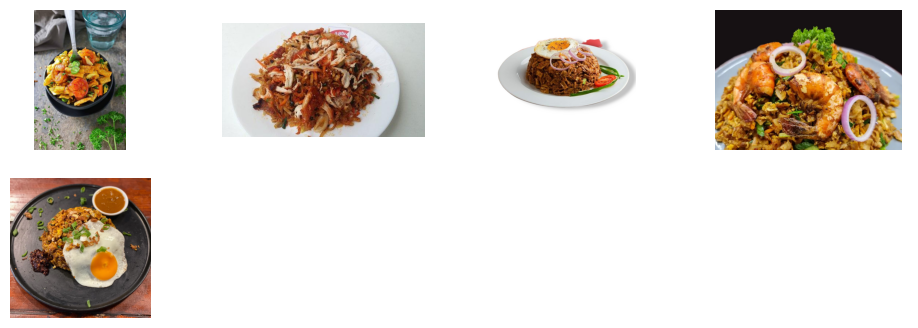

In [11]:
misclf_paths = [i for i, keep in zip(paths, find_misclf(targets, preds, "kottu")) if keep]

view_images(misclf_paths)

## Test out-of-distribution examples

In [7]:
from torch.utils.data import DataLoader

test_dataset = TestDataset('../data/', include_outliers=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

1025 images


In [42]:
import numpy as np

model.eval()

targets = []
preds = []
paths = []
with torch.no_grad():
    for data, target, _ , path in test_dataloader:
        data, target = data.to('cuda'), target.to('cuda')

        output = model(data)        
        targets += [0 if i == -1 else 1 for i in list(target.data.cpu().numpy())]
        
        exp_output = np.exp(output.cpu().numpy())
        max_p = np.max(exp_output, axis=1)/np.sum(exp_output, axis=1)
        preds += list(max_p)
        
        paths += list(path)
    
targets = np.array(targets)
preds = np.array(preds)

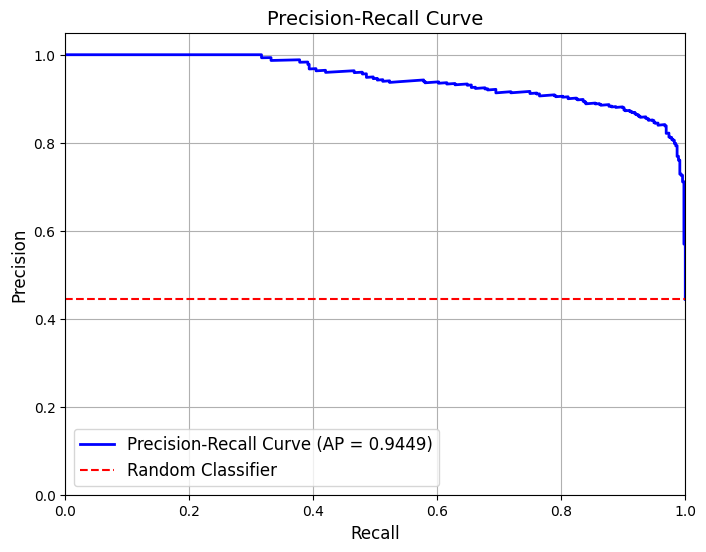

In [43]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

targets = np.array(targets)
preds = np.array(preds)

precision, recall, thresh = precision_recall_curve(targets, preds)

ap_score = average_precision_score(targets, preds)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {ap_score:.4f})', color='blue', lw=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)

no_skill = len(targets[targets == 1]) / len(targets)  # Fraction of positive class
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Classifier', color='red')

plt.legend(loc='lower left', fontsize=12)
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [44]:
EPS = 1e-6

def weighted_harmonic_mean(precision, recall, beta=1):
    return (1 + beta**2) * (precision * recall) / (beta**2 * (precision+EPS) + (recall+EPS))

score = weighted_harmonic_mean(precision, recall, beta=1.5)

best_idx = np.argmax(score)

print(score[best_idx])

best_threshold = thresh[best_idx]

best_threshold

0.9248255323894934


0.31544644

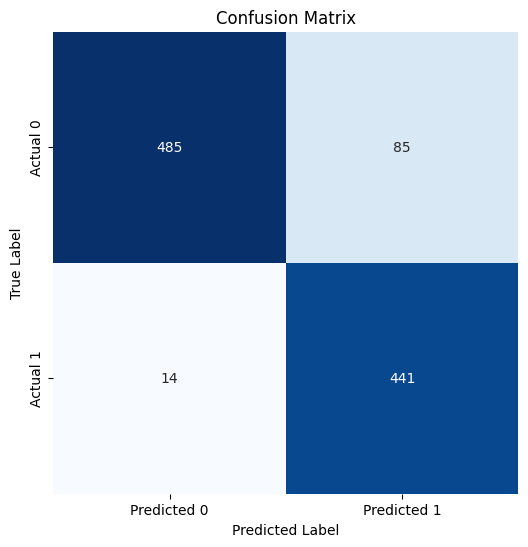

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

binary_preds = preds >= best_threshold

cm = confusion_matrix(targets, binary_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [46]:
import matplotlib.pyplot as plt
from PIL import Image

def find_misclf(targets, preds, is_fp):
    if is_fp:
        mismatch_filter = (targets == 0) & (preds == 1)
    else:
        mismatch_filter = (targets == 1) & (preds == 0)
        
    return mismatch_filter

def view_images(paths):
    num_columns = 4
    num_rows = (len(paths) + num_columns - 1) // num_columns  
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * 2))

    if num_rows > 1:
        for idx, i in enumerate(paths):
            img = Image.open(i)
            axes[idx // num_columns][idx % num_columns].imshow(np.array(img))  

        for i in range(num_rows):
            for j in range(num_columns):
                axes[i][j].axis('off')
    else:
        for idx, i in enumerate(paths):
            img = Image.open(i)
            axes[idx].imshow(np.array(img))  

        for i in range(num_columns):
            axes[i].axis('off')

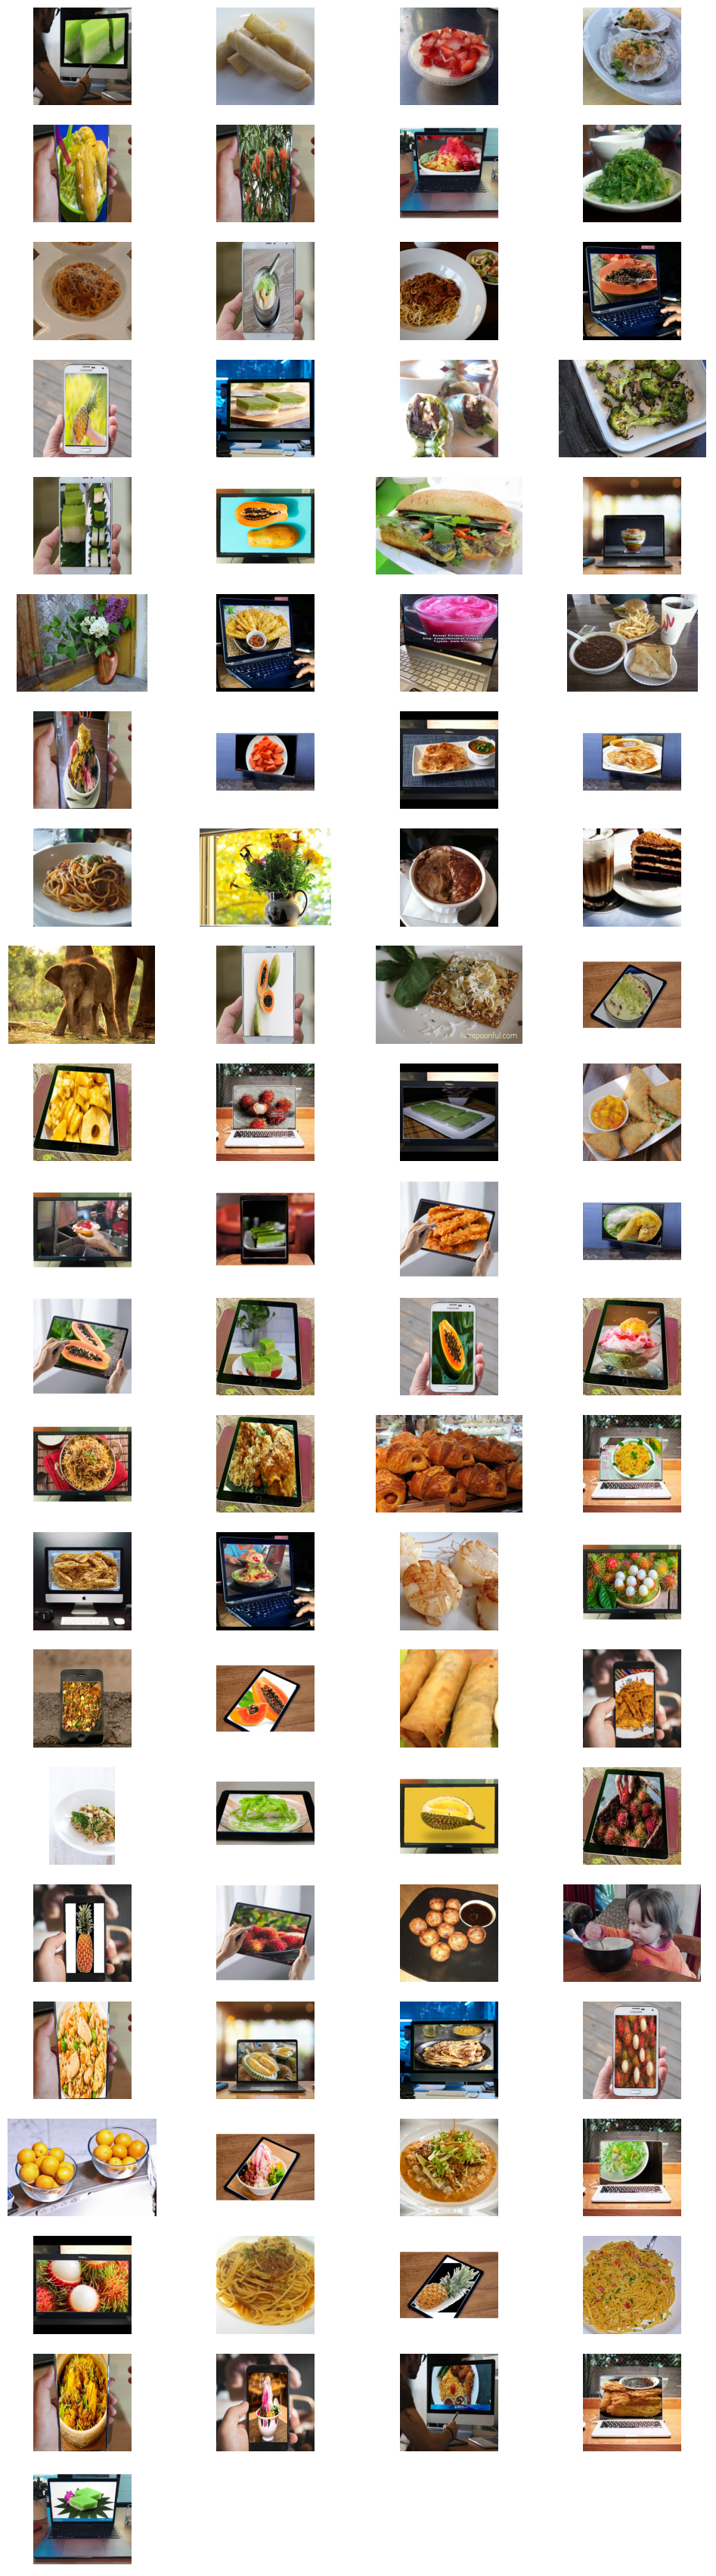

In [48]:
misclf_paths = [i for i, keep in zip(paths, find_misclf(targets, binary_preds, True)) if keep]

view_images(misclf_paths)

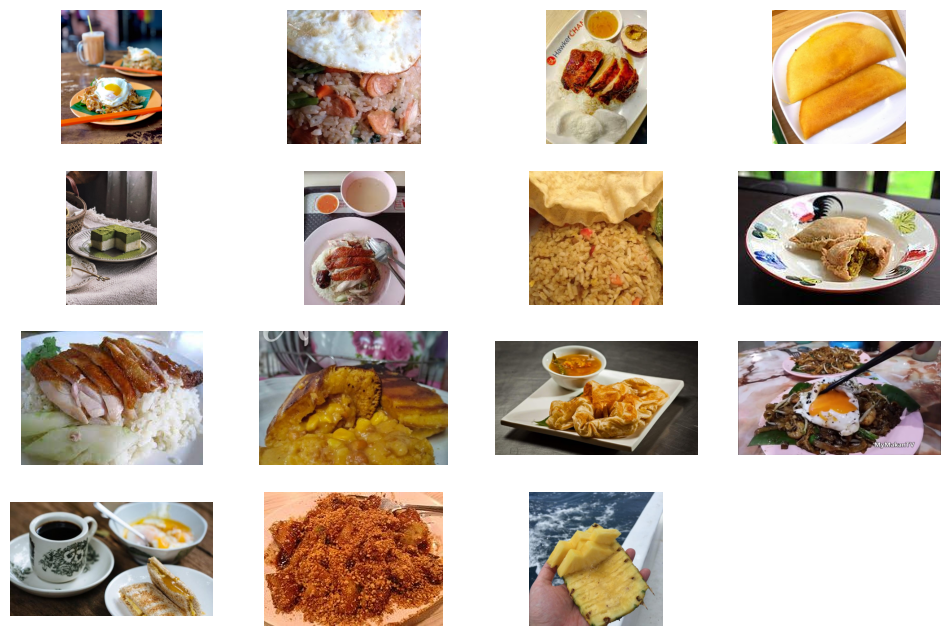

In [15]:
misclf_paths = [i for i, keep in zip(paths, find_misclf(targets, binary_preds, False)) if keep]

view_images(misclf_paths)

## Test custom example

In [10]:
import torchvision.transforms as transforms

IMG_SIZE = (224, 224)
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD),
])

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import json
import numpy as np

def predict(path):
    model.eval()
    ori_img = Image.open(path).convert("RGB")
    img = ori_img.resize((224, 224), Image.Resampling.LANCZOS)
    img = transform(img).cuda()
    labels = json.loads(open('../data/labels.json', 'r').read())
    
    output = model(img[None, :])
    
    exp_output = np.exp(output.detach().cpu().numpy())
    max_p = np.max(exp_output, axis=1)/np.sum(exp_output, axis=1)
    
    idx = output.max(1)[1][0]
    label = labels[idx]
    
    plt.imshow(ori_img)
    if max_p[0] >= 0.6:
        plt.title(f"Label: {label}, p: {max_p[0]:2f}")
    else:
        plt.title(f"No food found, max: {label} {max_p[0]:2f}")
    plt.show()

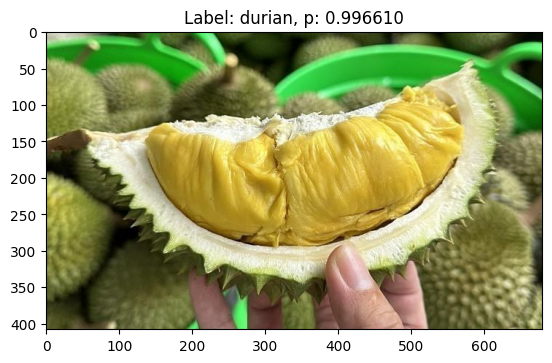

In [24]:
predict('./test_samples/durian.png')